In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers 
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()
AUTOTUNE = tf.data.experimental.AUTOTUNE
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256,256, 3])
    return image
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
print(monet_ds)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


In [2]:
def generator_model():
    model =tf.keras.Sequential()
    model.add(layers.Input(shape=(256,256,3)))
    model.add(layers.Conv2DTranspose(128,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(512,4,padding='same',strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(512,4,padding='same',strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(256,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(3,4,padding='same',activation='sigmoid'))
    return model

In [3]:
generator_monet=generator_model()
generator_photo=generator_model()
generated_image=generator_monet(next(iter(monet_ds)),training=False)

TensorShape([1, 256, 256, 3])

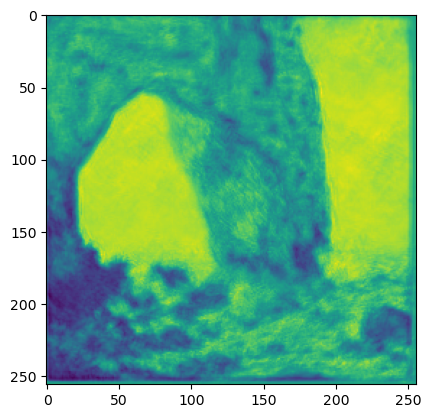

In [4]:
import matplotlib.pyplot as plt
plt.imshow(generated_image[0,:,:,0])
generated_image.shape

In [5]:
from tensorflow.keras.models import Model
def discrimatior_model():
    model =tf.keras.Sequential()
    model.add(layers.Input(shape=[256,256,3]))
    model.add(layers.Conv2D(128,4,strides=(1,1),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128,4,strides=(1,1),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(256,4,strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.ZeroPadding2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [6]:
discrimator=discrimatior_model()
print(discrimator(generated_image))

tf.Tensor([[0.06123035]], shape=(1, 1), dtype=float32)


In [7]:
monet_discrimator=discrimatior_model()
photo_discrimator=discrimatior_model()

In [8]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real,fake):
    real_loss=cross_entropy(tf.ones_like(real),real)
    fake_loss=cross_entropy(tf.zeros_like(fake),fake)
    loss=real_loss+fake_loss
    return loss
def generator_loss(fake):
    return cross_entropy(tf.zeros_like(fake),fake)
monet_generator_optimizer=tf.keras.optimizers.Adam(1e-4)
monet_discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)
photo_generator_optimizer=tf.keras.optimizers.Adam(1e-4)
photo_discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [9]:
@tf.function
def train_image(batch_data):
    real_monet,real_photo=batch_data
    with tf.GradientTape(persistent=True) as gen_tape,tf.GradientTape(persistent=True) as disc_tape:
        fake_monet=generator_monet(real_photo,training=True)
        cycled_photo=generator_photo(fake_monet,training=True)
        
        fake_photo=generator_photo(real_monet,training=True)
        cycled_monet=generator_monet(fake_photo,training=True)
        
        same_monet=generator_monet(real_monet,training=True)
        same_photo=generator_photo(real_photo,training=True)
        
        real_monet_output=monet_discrimator(same_monet,training=True)
        fake_monet_output=monet_discrimator(cycled_monet,training=True)
        
        real_photo_output=photo_discrimator(same_photo,training=True)
        fake_photo_output=photo_discrimator(cycled_photo,training=True)
        
        monet_gen_loss=generator_loss(fake_monet_output)
        photo_gen_loss=generator_loss(fake_photo_output)
        
        monet_disc_loss=discriminator_loss(real_monet_output,fake_monet_output)
        photo_disc_loss=discriminator_loss(real_photo_output,fake_photo_output)
    gradients_monet_generator=gen_tape.gradient(monet_gen_loss,generator_monet.trainable_variables)
    gradients_photo_generator=gen_tape.gradient(photo_gen_loss,generator_photo.trainable_variables)
    gradients_monet_discrimator=disc_tape.gradient(monet_disc_loss,monet_discrimator.trainable_variables)
    gradients_photo_discrimator=disc_tape.gradient(photo_disc_loss,photo_discrimator.trainable_variables)
    
    monet_generator_optimizer.apply_gradients(zip(gradients_monet_generator,generator_monet.trainable_variables))
    monet_discriminator_optimizer.apply_gradients(zip(gradients_monet_discrimator,monet_discrimator.trainable_variables))
    photo_generator_optimizer.apply_gradients(zip(gradients_photo_generator,generator_photo.trainable_variables))
    photo_discriminator_optimizer.apply_gradients(zip(gradients_photo_discrimator,photo_discrimator.trainable_variables))


In [10]:
import time
def train(epochs):
    for epoch in range(1,epochs):
        start=time.time()
        for batch in tf.data.Dataset.zip((load_dataset(MONET_FILENAMES, labeled=True).batch(epoch),load_dataset(PHOTO_FILENAMES, labeled=True).batch(epoch))):
            train_image(batch)

In [11]:
train(5)

2023-07-02 17:21:48.533967: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_6/dropout_1/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-02 17:40:06.280965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_6/dropout_1/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/conv2d_7/Conv2D_2' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_28/3106669267.py", line 1, in <module>
      train(5)
    File "/tmp/ipykernel_28/26967948.py", line 6, in train
      train_image(batch)
    File "/tmp/ipykernel_28/106584924.py", line 12, in train_image
      same_photo=generator_photo(real_photo,training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_1/conv2d_7/Conv2D_2'
OOM when allocating tensor with shape[2,512,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/conv2d_7/Conv2D_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_image_16672]

In [12]:
pred=generator_monet(next(iter(photo_ds)))


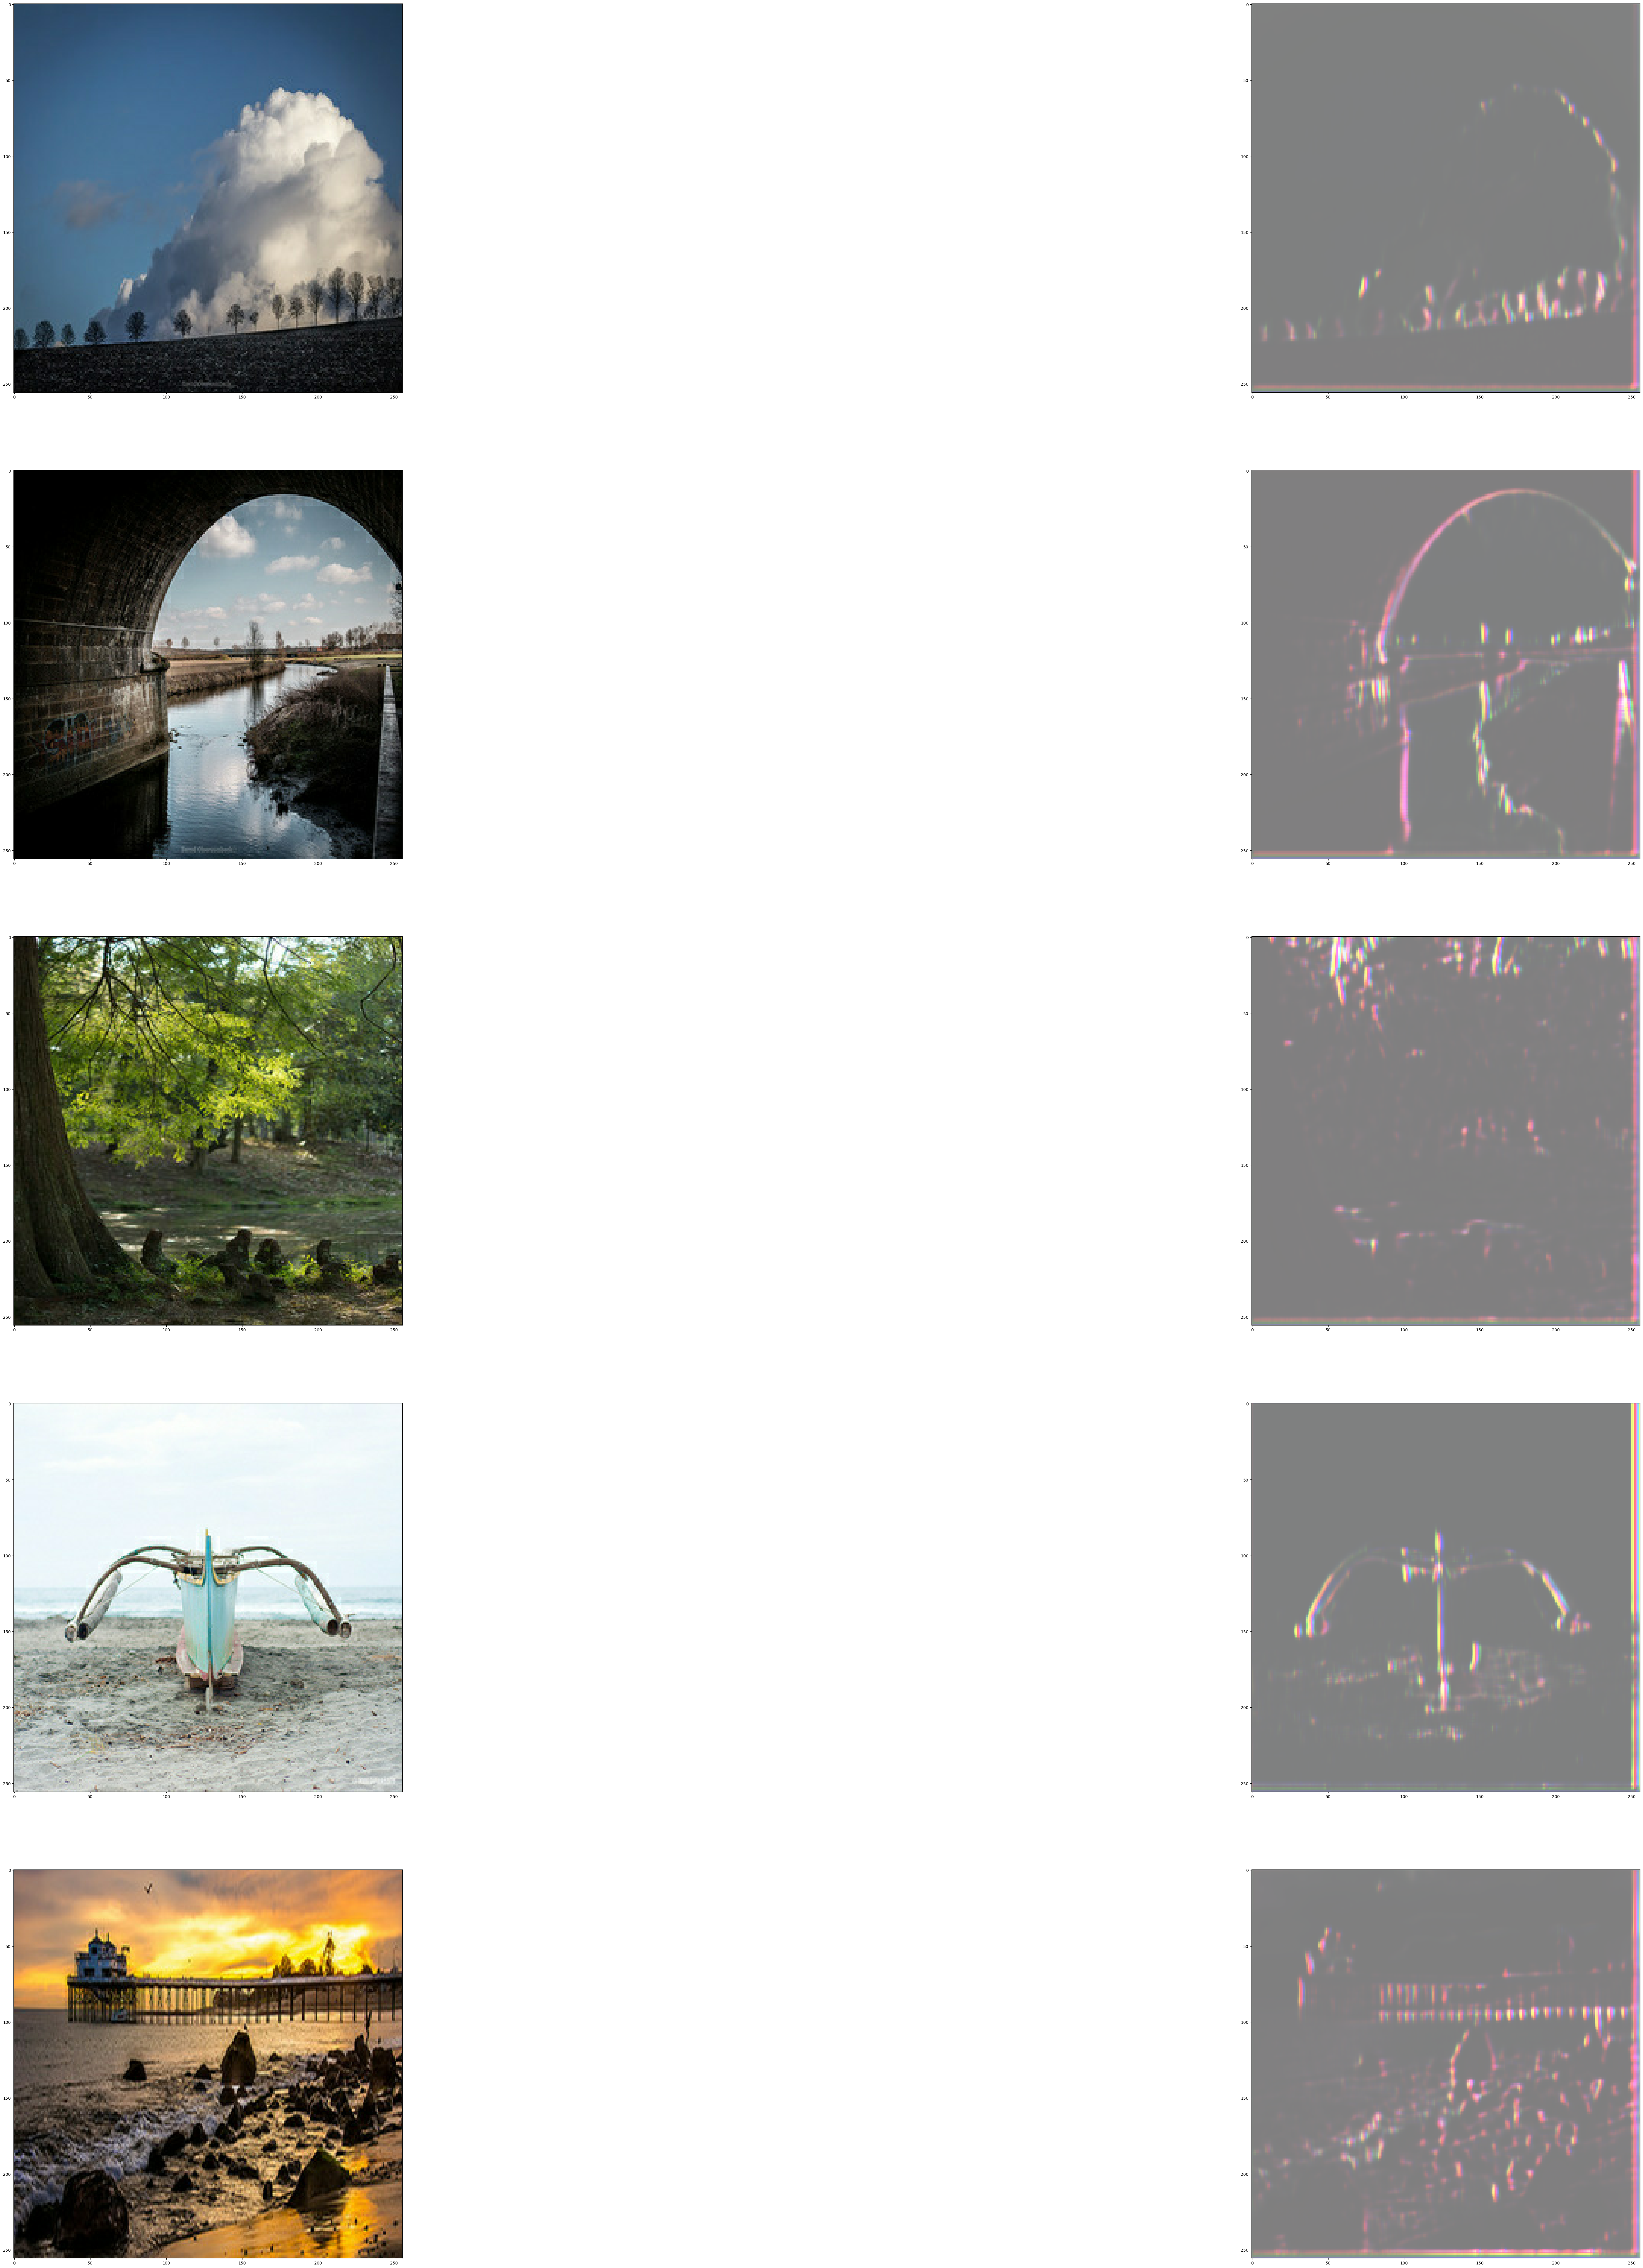

In [13]:
import numpy as np
_, ax = plt.subplots(5, 2, figsize=(100, 100))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)